Phython code for comparing performance of 4 clustering applied to 3 dataset with different properties
 - Goal :
      in order to provide guidelines for algorithm selection, comparing the performance of different clustering algorithms
      according to properties of data set
 - Compared Clustering Algorithms :
      K-Means, DBSCAN, Gaussian Mixture Model, Agglomerative hierachical clustering
 - Compared data sets from kaggle :
      iris, wine, credit card
 - Performance metrics :
      Silhouette Coefficient, Calinski-Harabasz Index, Davies-Bouldin Index, execution time
 - Experiments :
      The performance was analyzed using the original dataset and
      a reduced dataset using the UMAP(Uniform Manifold Approximation and Projection) and PCA(Principle Components Analysis)
 - Results :
      Performance improves with  data dimensionality reduction
      K-Means method with data reduction techniques performed well regardless of dataset properties
      DBSCAN combined with PCA performs well when the dataset structure is complex or highly clustered

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import seaborn as sns
from sklearn.cluster import KMeans, OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import SilhouetteVisualizer
import umap
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import torch

from random import sample

import statsmodels.api as sm
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import time
import csv

In [2]:
# read input files : CC GENERAL.csv, iris.csv, wine-clustering.csv
device = torch.device("mps")
url = 'CC GENERAL.csv'
df = pd.read_csv(os.getcwd()+'/Clustering/'+url)

# find structure of data set
print(df.shape)
print(df.describe())

(8950, 18)
            BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000       

In [3]:
# check the empty values : if (values is not 0) then empty
df.isna().mean()*100

CUST_ID                             0.000000
BALANCE                             0.000000
BALANCE_FREQUENCY                   0.000000
PURCHASES                           0.000000
ONEOFF_PURCHASES                    0.000000
INSTALLMENTS_PURCHASES              0.000000
CASH_ADVANCE                        0.000000
PURCHASES_FREQUENCY                 0.000000
ONEOFF_PURCHASES_FREQUENCY          0.000000
PURCHASES_INSTALLMENTS_FREQUENCY    0.000000
CASH_ADVANCE_FREQUENCY              0.000000
CASH_ADVANCE_TRX                    0.000000
PURCHASES_TRX                       0.000000
CREDIT_LIMIT                        0.011173
PAYMENTS                            0.000000
MINIMUM_PAYMENTS                    3.497207
PRC_FULL_PAYMENT                    0.000000
TENURE                              0.000000
dtype: float64

In [4]:
# remove non-numeric columns
df = df.select_dtypes(exclude=["object"])

# handling columns with empty values
# 1. remove the row that contains the column
# 2. Replace the value in that column with another value
policy = 1
if (policy ==1) :
    df = df.dropna(how="any")
if (policy !=1) :
    for col in df.columns:
        if df[col].isnull().any():
            df[col].fillna(df[col].mean(), inplace=True)

In [5]:
df.isna().mean()*100

BALANCE                             0.0
BALANCE_FREQUENCY                   0.0
PURCHASES                           0.0
ONEOFF_PURCHASES                    0.0
INSTALLMENTS_PURCHASES              0.0
CASH_ADVANCE                        0.0
PURCHASES_FREQUENCY                 0.0
ONEOFF_PURCHASES_FREQUENCY          0.0
PURCHASES_INSTALLMENTS_FREQUENCY    0.0
CASH_ADVANCE_FREQUENCY              0.0
CASH_ADVANCE_TRX                    0.0
PURCHASES_TRX                       0.0
CREDIT_LIMIT                        0.0
PAYMENTS                            0.0
MINIMUM_PAYMENTS                    0.0
PRC_FULL_PAYMENT                    0.0
TENURE                              0.0
dtype: float64

In [6]:
df.shape

(8636, 17)

In [7]:
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12
5,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12


In [8]:
# functions for exploratory data analysis

# function for skewness with data, method(normal|log|sqrt), draw plot(True|False)
#    Symmetrical (-0.5 < skewness < 0.5), 
#    moderately skewed (-1 to -0.5, 0.5 to 1), 
#    otherwise highly skewed.

def skewness(df, method = 'normal', plot='Fale') :
    skew_r = {}
    if (method == 'normal') :
        for feature in df:
            tempData = df.sort_values(by=feature)[feature]
            skew_r[feature] = tempData.skew()
           
        if plot=='True':
            sns.displot(tempData)

    if (method == 'log') : 
        for feature in df:
            tempData = np.log(df.sort_values(by=feature)[feature])
            skew_r[feature] = tempData.skew()
       
        if plot=='True':
            sns.displot(tempData)

    if (method == 'sqrt') : 
        for feature in df:
            tempData = np.sqrt(df.sort_values(by=feature)[feature])
            skew_r[feature] = tempData.skew()
        
        if plot=='True':
            sns.displot(tempData)
           
    return skew_r

In [9]:
# check whether the dataset is suitable for clustering. 
# function for calculating hopkins static used to check whether the dataset is randomly distributed
# A value close to 0.5 indicates that the data has a random distribution, and therefore is not suitable for clustering. 
# On the other hand, if the value is greater than 0.7, the dataset is likely suitable for clustering.

def hopkins(X):
    d = X.shape[1] # columns
    n = X.shape[0] # rows

    m = int(0.1 * n) # heuristic from article [1]

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X)
    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(np.random.normal(size=(1, d)).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X[rand_X[j]].reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    return  H

In [10]:
# functions for outlier remove with dataframe, method(IQR|z_score)
# remove outlier based on quartiles : IQR(Interquantile Range)
# IQR = Q3(상위 25%)-Q1(하위 25%)
# 이상치 = (Q1-1.5*IQR) 보다 작거나 Q3+1.5∗IQR보다 큰 경우
# 1.5 대신 다른 수를 곱할 수도 있음

def outlier_remove(df, method='IQR', threshold=1.5):
    
    # initialization
    outlier_percentage = {}
    df_rows = np.zeros(df.shape[0])    # outlier가 포함되어 있는 행에 대한 정보 유지
    df_filtered = df.copy()            # outlier가 제외된 데이터셋

# remove outlier based on quartiles : IQR(Interquantile Range)
# IQR = Q3(upper 25%)-Q1(lower 25%)
# outlier = ((Q1-1.5*IQR) > values) | (value > (Q3+1.5∗IQR))
# defalut threshold = 1.5
    
    if (method == 'IQR'):
        for feature in df:
            tempData = df[feature]
            data = tempData.to_numpy()
            Q1, Q3 = tempData.quantile([0.25, 0.75])
            IQR = Q3 - Q1
            Lower_range = Q1 - (threshold * IQR)       
            Upper_range = Q3 + (threshold * IQR)
            # outlier 갯수 구하기
            filtered_data = data[(Lower_range < tempData) & (tempData < Upper_range)] 
            outlier = data[(tempData < Lower_range) | (tempData > Upper_range)]
            outlier_percentage[feature] = round((len(outlier)/len(data)) * 100, 2)

            for i in range(df.shape[0]):
                if ((Lower_range > data[i]) | (data[i] > Upper_range)):
                    df_rows[i] = 1

# remove outlier based on z-score
# How many standard deviations the data deviates from the mean.
# Classify anything over 3 as an outlier based on the normal absolute value
# Z = (x-u)/a  x : data, u : mean, a : stansard deviation
# defalut threshold = 3
    if (method == 'z_score'):
        for feature in df:
            data = df[feature].to_numpy()
            z_scores = np.abs(data - np.mean(data)) / np.std(data) # Z-score 계산      
            filtered_data = data[z_scores < threshold]
            outlier = data[z_scores>threshold]
            outlier_percentage[feature] = round((len(outlier)/len(data)) * 100, 2)

            # outlier 되어야 할 행에 대한 정보 관리
            for i in range(df.shape[0]):
                if (z_scores>threshold):
                    df_rows[i] = 1
        
    return df_filtered, outlier_percentage


# plot scatter based on clustering results
#   X, Y           : dataframe
#   clusters       : no. of clusters
#   size_x, size_y : size of fig

In [11]:
def DrawScatter(X, Y, clusters, labels, size_x, size_y) :

    cmap = plt.cm.get_cmap("viridis", clusters)
    fig = plt.figure(figsize=(size_x, size_y))
    #colors = plt.cm.Spectral(labels / clusters)
 
    for i in range(clusters) :
        plt.scatter(X[labels == i, 0], X[labels == i, 1], cmap = cmap, label=f'Cluster {i}', s=10)
    plt.legend()
    return

In [12]:
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12
5,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12


In [13]:
# function for scaling
def scaling(df) :
    SS=StandardScaler()
    df_scaled=SS.fit_transform(df[df.columns])
    
    return df_scaled

In [14]:
df_scaled = scaling(df)

In [15]:
pd.DataFrame(df_scaled).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.744625,-0.370047,-0.429184,-0.359160,-0.354826,-0.468655,-0.820769,-0.686280,-0.717179,-0.681953,-0.479437,-0.517623,-0.962575,-0.543942,-0.305508,-0.537727,0.355181
1,0.764152,0.067679,-0.473208,-0.359160,-0.458839,2.568556,-1.236139,-0.686280,-0.926522,0.557022,0.099258,-0.597054,0.677204,0.796852,0.087689,0.212380,0.355181
2,0.426602,0.505405,-0.116413,0.099909,-0.458839,-0.468655,1.256077,2.646651,-0.926522,-0.681953,-0.479437,-0.120467,0.813852,-0.399503,-0.099906,-0.537727,0.355181
3,-0.373910,0.505405,-0.465825,-0.349660,-0.458839,-0.468655,-1.028455,-0.408536,-0.926522,-0.681953,-0.479437,-0.557339,-0.907916,-0.380165,-0.261131,-0.537727,0.355181
4,0.099551,0.505405,0.142062,-0.359160,0.994815,-0.468655,0.425339,-0.686280,0.538882,-0.681953,-0.479437,-0.279329,-0.743938,-0.132119,0.650363,-0.537727,0.355181


In [16]:
#skewness normal
skew_r = skewness(df, method = 'normal', plot='False')
print(skew_r)

{'BALANCE': 2.374254166807351, 'BALANCE_FREQUENCY': -2.0841614822186636, 'PURCHASES': 8.055789007455493, 'ONEOFF_PURCHASES': 9.935775932966447, 'INSTALLMENTS_PURCHASES': 7.216133308729193, 'CASH_ADVANCE': 5.13962856566708, 'PURCHASES_FREQUENCY': 0.033041216293616574, 'ONEOFF_PURCHASES_FREQUENCY': 1.5042342334651349, 'PURCHASES_INSTALLMENTS_FREQUENCY': 0.48775295432449606, 'CASH_ADVANCE_FREQUENCY': 1.7959150389505736, 'CASH_ADVANCE_TRX': 5.673326830236881, 'PURCHASES_TRX': 4.578418450576066, 'CREDIT_LIMIT': 1.5070190408804252, 'PAYMENTS': 5.873048586774974, 'MINIMUM_PAYMENTS': 13.622193089492017, 'PRC_FULL_PAYMENT': 1.8860271302192855, 'TENURE': -3.011140522570409}


In [17]:
#skewness log
skew_r = skewness(pd.DataFrame(df_scaled), method = 'log', plot='False')
print(skew_r)

{0: -1.1031277321529975, 1: -3.561522279242786, 2: -0.7089390391073944, 3: -0.6169880283083033, 4: -0.8108799891189911, 5: -1.277280218965453, 6: -2.2507726818691913, 7: -0.6710524466909377, 8: -1.4001209649174908, 9: -0.48019017534897485, 10: -0.05020391595663618, 11: -0.25006287415115025, 12: -0.4391783730810097, 13: -0.675239963812379, 14: -0.31249081918299354, 15: -1.273988631390395, 16: 0.0}


C:\Users\KDMoon\miniforge3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
#skewness sqrt
skew_r = skewness(pd.DataFrame(df_scaled), method = 'sqrt', plot='False')
print(skew_r)

C:\Users\KDMoon\miniforge3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


{0: 0.5873177476028105, 1: -3.411146885617264, 2: 1.9012520353210418, 3: 2.1411144629482837, 4: 1.6804033251186714, 5: 1.1676864738391783, 6: -1.3413200321897318, 7: -0.1148828411561928, 8: -0.8637646937905424, 9: 0.41446946390820605, 10: 1.4640678035183368, 11: 1.3533687805386394, 12: 0.5886489531320847, 13: 1.5814404438556635, 14: 2.899756092468734, 15: -0.3757240203169682, 16: 0.0}


In [20]:
# measuring the cluster tendency of a data set

hopkins_score = hopkins(df_scaled)
print(hopkins_score)

0.7929464183597794


In [21]:
# measuring and removing the outlier of a data set

df_filtered, outlier_percentage = outlier_remove(df, method='IQR', threshold=1.5)

print(outlier_percentage)

{'BALANCE': 7.71, 'BALANCE_FREQUENCY': 17.5, 'PURCHASES': 8.89, 'ONEOFF_PURCHASES': 11.13, 'INSTALLMENTS_PURCHASES': 9.39, 'CASH_ADVANCE': 11.31, 'PURCHASES_FREQUENCY': 0.0, 'ONEOFF_PURCHASES_FREQUENCY': 8.67, 'PURCHASES_INSTALLMENTS_FREQUENCY': 0.0, 'CASH_ADVANCE_FREQUENCY': 3.95, 'CASH_ADVANCE_TRX': 9.19, 'PURCHASES_TRX': 8.29, 'CREDIT_LIMIT': 2.81, 'PAYMENTS': 9.09, 'MINIMUM_PAYMENTS': 9.74, 'PRC_FULL_PAYMENT': 15.55, 'TENURE': 14.94}


In [39]:
# dictionary for storing results

results = {
    "KMeans": {
        "normal": {},
        "umap": {},
        "pca": {},
    },
    "DBSCAN": {
        "normal": {},
        "umap": {},
        "pca": {}
    },
    "GMM": {
        "normal": {},
        "umap": {},
        "pca": {}
    },
    "AGL": {
        "normal": {},
        "umap": {},
        "pca": {}
    }
}

K-Means Normal with original dataset

Silhouette Coefficient: 0.21
Calinski-Harabasz Index: 1509.81
Davies-Bouldin Index: 1.66
Time: 0.01
N_clusters: 3.00


C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", clusters)
C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[labels == i, 0], X[labels == i, 1], cmap = cmap, label=f'Cluster {i}', s=10)


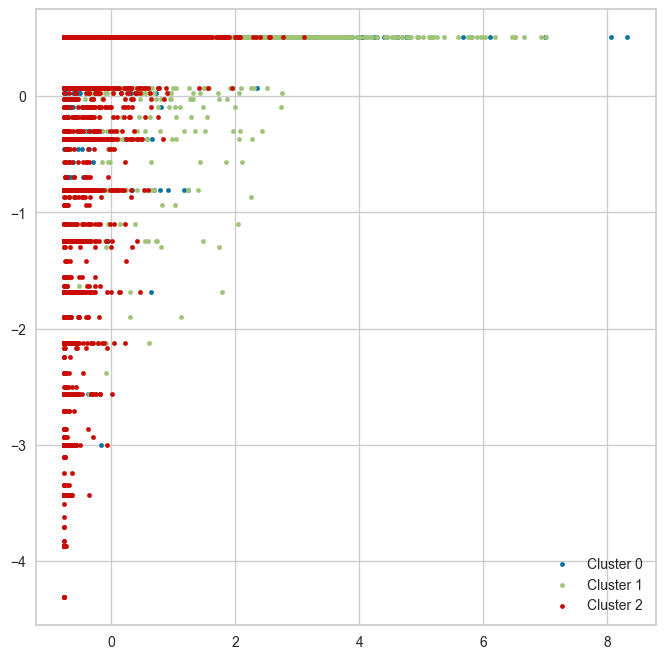

In [23]:
n = 3

start = time.time()
kmeans_normal = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init='auto', random_state=0)
kmeans_labels_normal = kmeans_normal.fit_predict(df_scaled)  
end = time.time()

n_clusters = len(set(kmeans_normal.labels_))
results["KMeans"]["normal"]["Silhouette Coefficient"] = silhouette_score(df_scaled, kmeans_labels_normal)
results["KMeans"]["normal"]["Calinski-Harabasz Index"] = calinski_harabasz_score(df_scaled, kmeans_labels_normal)
results["KMeans"]["normal"]["Davies-Bouldin Index"] = davies_bouldin_score(df_scaled, kmeans_labels_normal)
results["KMeans"]["normal"]["Time"] = end - start
results["KMeans"]["normal"]["N_clusters"] = n_clusters

for metric, value in results["KMeans"]["normal"].items():
    print(f"{metric}: {value:.2f}")

DrawScatter(df_scaled, df_scaled, clusters = n_clusters, labels = kmeans_labels_normal, size_x=8, size_y=8)

K-Means with UMAP

In [24]:
distance = "euclidean" # "euclidean","cosine","correlation"

reducer = umap.UMAP(metric = distance)
embedding = reducer.fit_transform(df_scaled)
df_umap = pd.DataFrame(embedding, columns=['UMAP 1', 'UMAP 2'])


#df_umap = pd.DataFrame(embedding)

Silhouette Coefficient: 0.44
Calinski-Harabasz Index: 8575.22
Davies-Bouldin Index: 0.81
Time: 0.07
N_clusters: 3.00


C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", clusters)
C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[labels == i, 0], X[labels == i, 1], cmap = cmap, label=f'Cluster {i}', s=10)


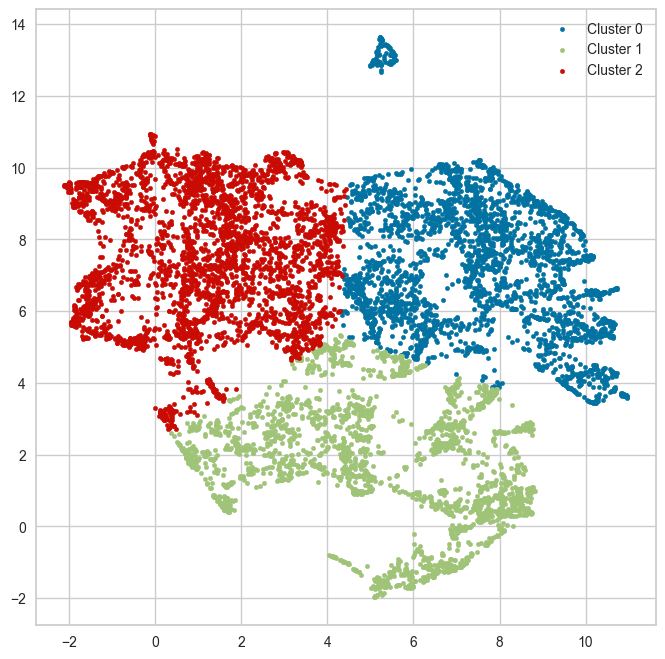

In [25]:
n = 3

start = time.time()
kmeans_umap = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_labels_umap = kmeans_umap.fit_predict(df_umap)
end = time.time()

n_clusters = len(set(kmeans_umap.labels_))
results["KMeans"]["umap"]["Silhouette Coefficient"] = silhouette_score(df_umap, kmeans_labels_umap)
results["KMeans"]["umap"]["Calinski-Harabasz Index"] = calinski_harabasz_score(df_umap, kmeans_labels_umap)
results["KMeans"]["umap"]["Davies-Bouldin Index"] = davies_bouldin_score(df_umap, kmeans_labels_umap)
results["KMeans"]["umap"]["Time"] = end-start
results["KMeans"]["umap"]["N_clusters"] = n_clusters

for metric, value in results["KMeans"]["umap"].items():
    print(f"{metric}: {value:.2f}")
    
DrawScatter(df_umap.values, df_umap.values, clusters = n_clusters, labels = kmeans_labels_umap, size_x=8, size_y=8)

K-Means with PCA

In [26]:
k=3
pca = PCA(n_components=k)
df_pca = pca.fit_transform(df_scaled)

Silhouette Coefficient: 0.37
Calinski-Harabasz Index: 3656.71
Davies-Bouldin Index: 0.98
Time: 0.06
N_clusters: 3.00


C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", clusters)
C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[labels == i, 0], X[labels == i, 1], cmap = cmap, label=f'Cluster {i}', s=10)


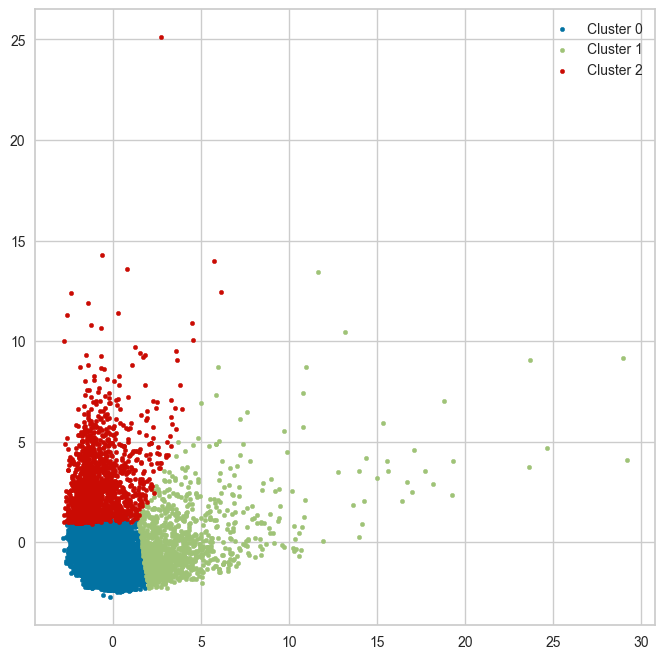

In [27]:
n = 3
start = time.time()
kmeans_pca = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_labels_pca = kmeans_pca.fit_predict(df_pca)
end = time.time()

n_clusters = len(set(kmeans_pca.labels_))
results["KMeans"]["pca"]["Silhouette Coefficient"] = silhouette_score(df_pca, kmeans_labels_pca)
results["KMeans"]["pca"]["Calinski-Harabasz Index"] = calinski_harabasz_score(df_pca, kmeans_labels_pca)
results["KMeans"]["pca"]["Davies-Bouldin Index"] = davies_bouldin_score(df_pca, kmeans_labels_pca)
results["KMeans"]["pca"]["Time"] = end - start
results["KMeans"]["pca"]["N_clusters"] = n_clusters

for metric, value in results["KMeans"]["pca"].items():
    print(f"{metric}: {value:.2f}")

DrawScatter(df_pca, df_pca, clusters = n_clusters, labels = kmeans_labels_pca, size_x=8, size_y=8)

DBSCAN with original dataset

Silhouette Coefficient: 0.52
Calinski-Harabasz Index: 901.35
Davies-Bouldin Index: 1.98
Time: 0.28
N_clusters: 2.00


C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", clusters)
C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[labels == i, 0], X[labels == i, 1], cmap = cmap, label=f'Cluster {i}', s=10)


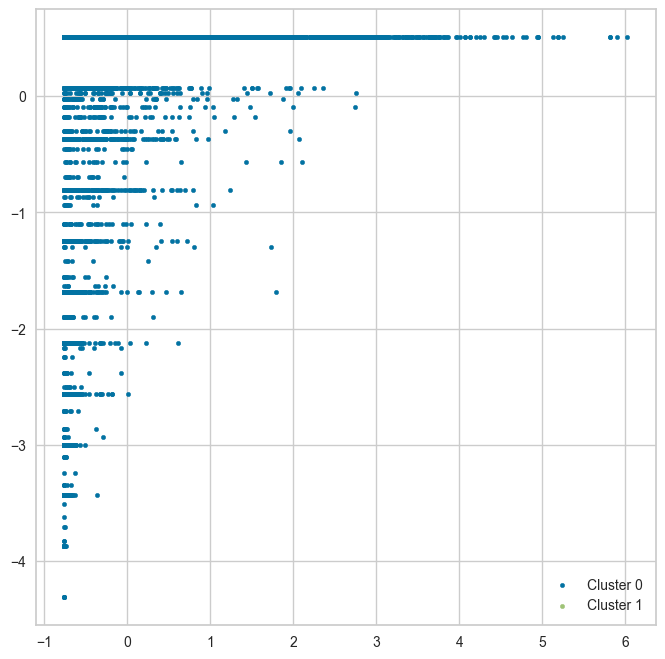

In [28]:
start = time.time()
dbscan_normal = DBSCAN(eps=2.23, min_samples=5)
dbscan_labels_normal = dbscan_normal.fit_predict(df_scaled)
end = time.time()

n_clusters = len(set(dbscan_normal.labels_))
results["DBSCAN"]["normal"]["Silhouette Coefficient"] = silhouette_score(df_scaled, dbscan_labels_normal) if len(np.unique(dbscan_labels_normal)) > 1 else 0
results["DBSCAN"]["normal"]["Calinski-Harabasz Index"] = calinski_harabasz_score(df_scaled, dbscan_labels_normal) if len(np.unique(dbscan_labels_normal)) > 1 else 0
results["DBSCAN"]["normal"]["Davies-Bouldin Index"] = davies_bouldin_score(df_scaled, dbscan_labels_normal) if len(np.unique(dbscan_labels_normal)) > 1 else 0
results["DBSCAN"]["normal"]["Time"] = end - start
results["DBSCAN"]["normal"]["N_clusters"] = n_clusters

for metric, value in results["DBSCAN"]["normal"].items():
    print(f"{metric}: {value:.2f}")

DrawScatter(df_scaled, df_scaled, clusters = n_clusters, labels = dbscan_labels_normal, size_x=8, size_y=8)

DBSCAN with UMAP

Silhouette Coefficient: -0.41
Calinski-Harabasz Index: 189.34
Davies-Bouldin Index: 1.76
Time: 0.06
N_clusters: 114.00


C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", clusters)
C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[labels == i, 0], X[labels == i, 1], cmap = cmap, label=f'Cluster {i}', s=10)


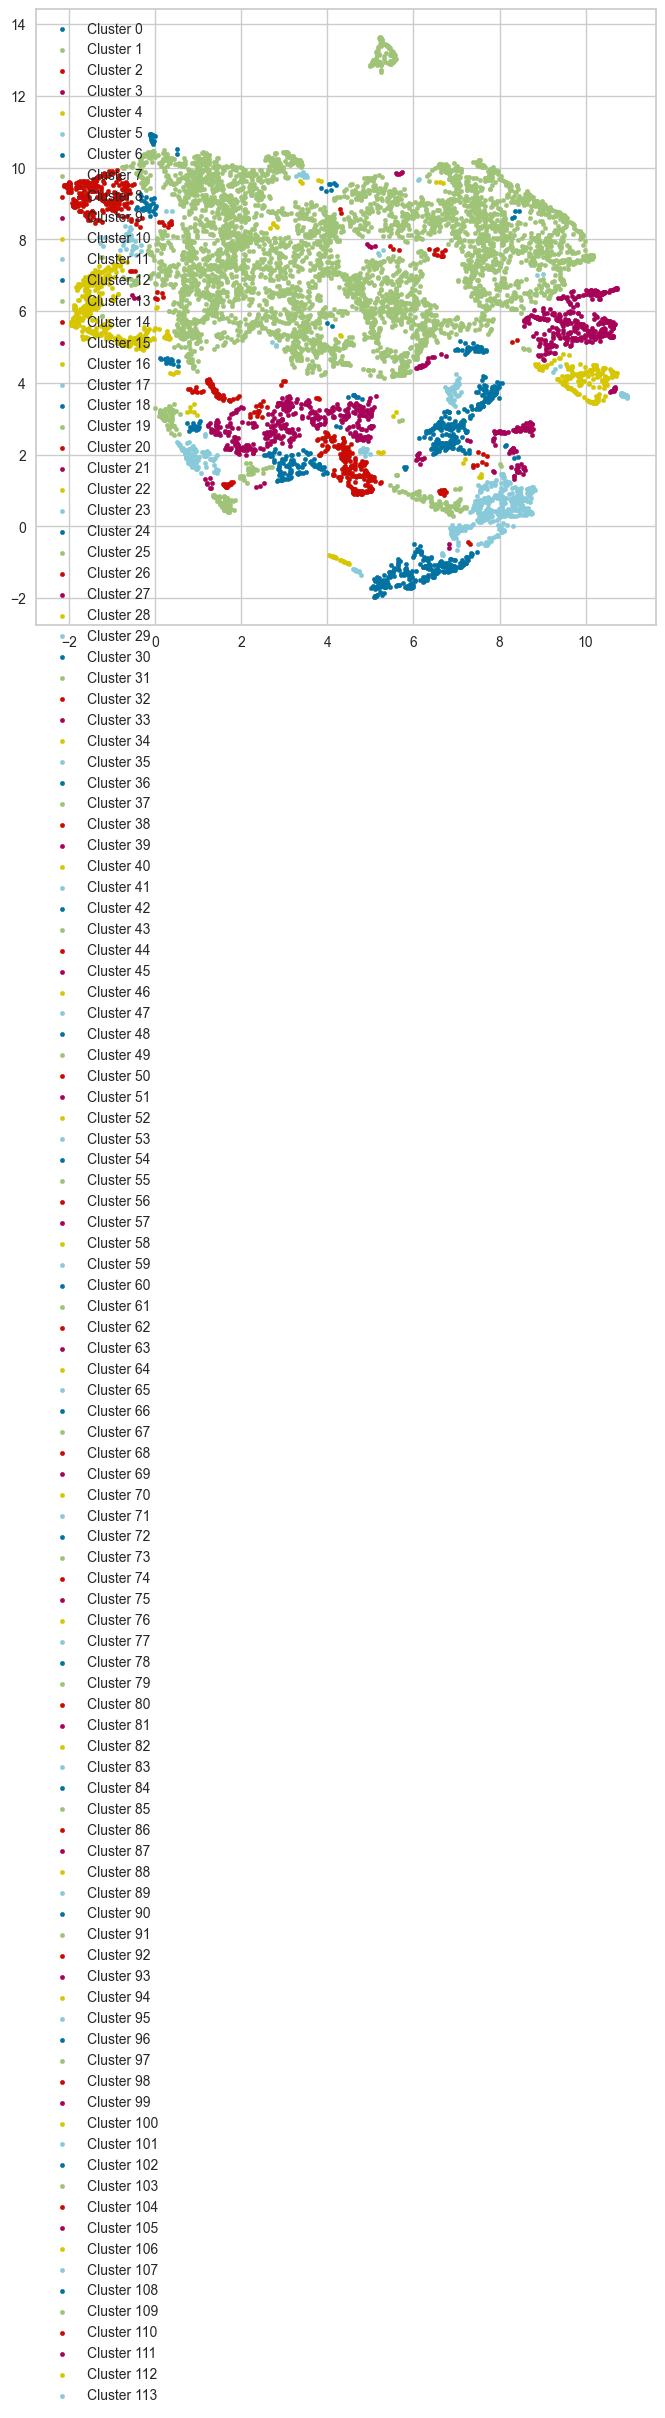

In [29]:
start = time.time()
dbscan_umap = DBSCAN(eps=0.15, min_samples=2)
dbscan_labels_umap = dbscan_umap.fit_predict(df_umap)
end = time.time()

n_clusters = len(set(dbscan_umap.labels_))
results["DBSCAN"]["umap"]["Silhouette Coefficient"] = silhouette_score(df_umap, dbscan_labels_umap) if len(np.unique(dbscan_labels_umap)) > 1 else 0
results["DBSCAN"]["umap"]["Calinski-Harabasz Index"] = calinski_harabasz_score(df_umap, dbscan_labels_umap)
results["DBSCAN"]["umap"]["Davies-Bouldin Index"] = davies_bouldin_score(df_umap, dbscan_labels_umap)
results["DBSCAN"]["umap"]["Time"] = end - start
results["DBSCAN"]["umap"]["N_clusters"] = n_clusters

for metric, value in results["DBSCAN"]["umap"].items():
    print(f"{metric}: {value:.2f}")

DrawScatter(df_umap.values, df_umap.values, clusters = n_clusters, labels = dbscan_labels_umap, size_x=8, size_y=8)

DBSCAN with PCA

Silhouette Coefficient: 0.54
Calinski-Harabasz Index: 333.85
Davies-Bouldin Index: 1.42
Time: 0.38
N_clusters: 6.00


C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", clusters)
C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[labels == i, 0], X[labels == i, 1], cmap = cmap, label=f'Cluster {i}', s=10)


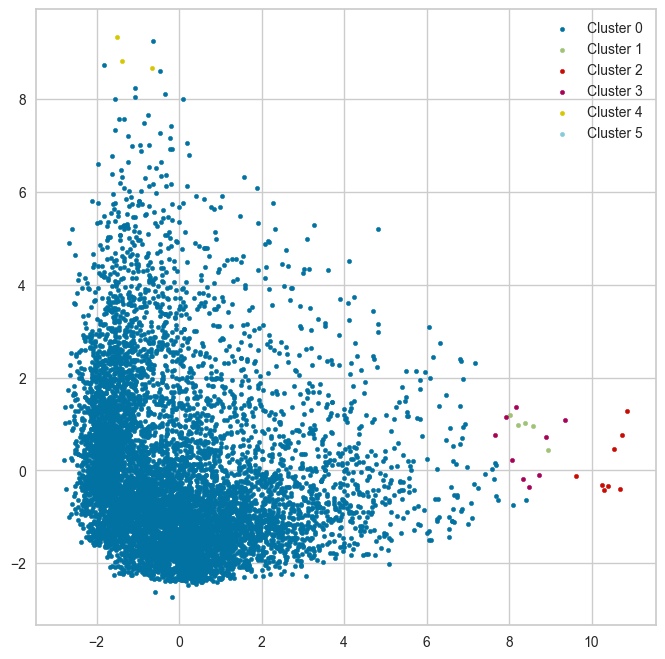

In [30]:
start = time.time()
dbscan_pca = DBSCAN(eps=1, min_samples=5)
dbscan_labels_pca = dbscan_pca.fit_predict(df_pca)
end = time.time()


n_clusters = len(set(dbscan_pca.labels_))
results["DBSCAN"]["pca"]["Silhouette Coefficient"] = silhouette_score(df_pca, dbscan_labels_pca) if len(np.unique(dbscan_labels_pca)) > 1 else 0
results["DBSCAN"]["pca"]["Calinski-Harabasz Index"] = calinski_harabasz_score(df_pca, dbscan_labels_pca)
results["DBSCAN"]["pca"]["Davies-Bouldin Index"] = davies_bouldin_score(df_pca, dbscan_labels_pca)
results["DBSCAN"]["pca"]["Time"] = end - start
results["DBSCAN"]["pca"]["N_clusters"] = n_clusters

for metric, value in results["DBSCAN"]["pca"].items():
    print(f"{metric}: {value:.2f}")

DrawScatter(df_pca, df_pca, clusters = n_clusters, labels = dbscan_labels_pca, size_x=8, size_y=8)

Silhouette Coefficient: 0.21
Calinski-Harabasz Index: 1509.81
Davies-Bouldin Index: 1.66
Time: 0.01
N_clusters: 3.00


C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", clusters)
C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[labels == i, 0], X[labels == i, 1], cmap = cmap, label=f'Cluster {i}', s=10)


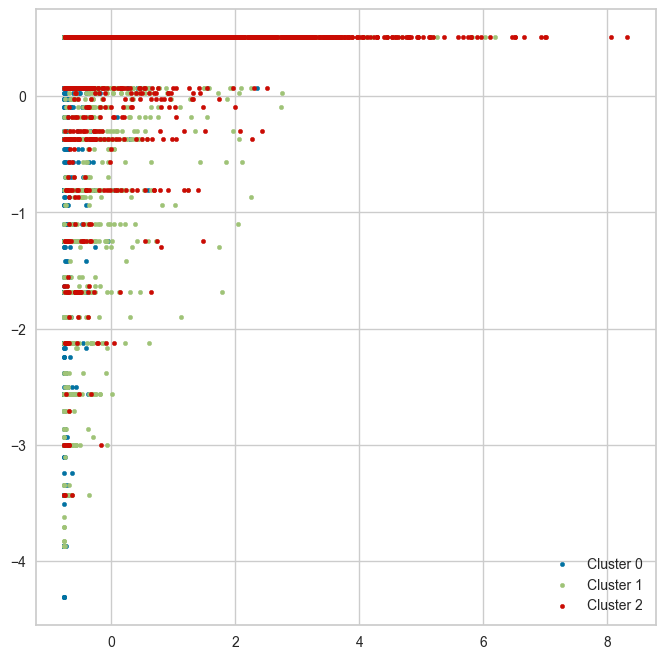

In [31]:
start = time.time()
gmm_normal = GaussianMixture(n_components=3, covariance_type='full', init_params='kmeans', random_state=42, n_init=10)
gmm_labels_normal = gmm_normal.fit_predict(df_scaled)
end = time.time()

n_clusters = len(np.unique(gmm_labels_normal))
results["GMM"]["normal"]["Silhouette Coefficient"] = silhouette_score(df_scaled, gmm_labels_normal)
results["GMM"]["normal"]["Calinski-Harabasz Index"] = calinski_harabasz_score(df_scaled, gmm_labels_normal)
results["GMM"]["normal"]["Davies-Bouldin Index"] = davies_bouldin_score(df_scaled, gmm_labels_normal)
results["GMM"]["normal"]["Time"] = end - start
results["GMM"]["normal"]["N_clusters"] = n_clusters

for metric, value in results["KMeans"]["normal"].items():
    print(f"{metric}: {value:.2f}")
    
DrawScatter(df_scaled, df_scaled, clusters = n_clusters, labels = gmm_labels_normal, size_x=8, size_y=8)

GMM with UMAP

Silhouette Coefficient: 0.43
Calinski-Harabasz Index: 8328.81
Davies-Bouldin Index: 0.81
Time: 0.31
N_clusters: 3.00


C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", clusters)
C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[labels == i, 0], X[labels == i, 1], cmap = cmap, label=f'Cluster {i}', s=10)


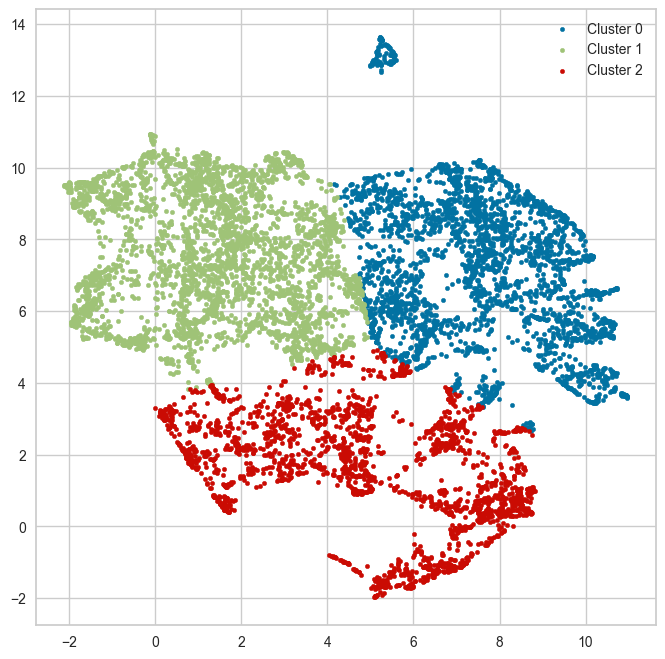

In [32]:
start = time.time()
gmm_umap = GaussianMixture(n_components=3, covariance_type='full', init_params='kmeans', random_state=42, n_init=10)
gmm_labels_umap = gmm_umap.fit_predict(df_umap)
end = time.time()

n_clusters = len(np.unique(gmm_labels_umap))
results["GMM"]["umap"]["Silhouette Coefficient"] = silhouette_score(df_umap, gmm_labels_umap)
results["GMM"]["umap"]["Calinski-Harabasz Index"] = calinski_harabasz_score(df_umap, gmm_labels_umap)
results["GMM"]["umap"]["Davies-Bouldin Index"] = davies_bouldin_score(df_umap, gmm_labels_umap)
results["GMM"]["umap"]["Time"] = end - start
results["GMM"]["umap"]["N_clusters"] = n_clusters

for metric, value in results["GMM"]["umap"].items():
    print(f"{metric}: {value:.2f}")

DrawScatter(df_umap.values, df_umap.values, clusters = n_clusters, labels = gmm_labels_umap, size_x=8, size_y=8)

GMM with PCA

Silhouette Coefficient: 0.23
Calinski-Harabasz Index: 2255.52
Davies-Bouldin Index: 1.36
Time: 0.86
N_clusters: 3.00


C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", clusters)
C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[labels == i, 0], X[labels == i, 1], cmap = cmap, label=f'Cluster {i}', s=10)


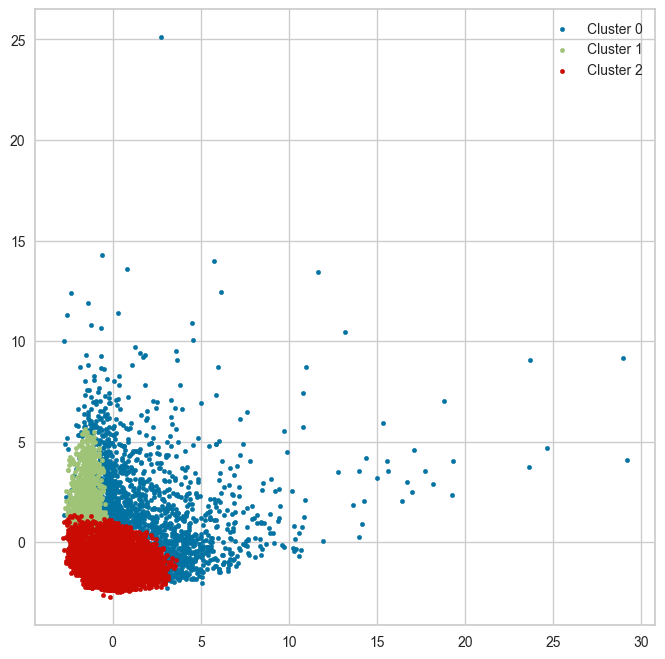

In [33]:
start = time.time()
gmm_pca = GaussianMixture(n_components=3, covariance_type='full', init_params='kmeans', random_state=42, n_init=10)
gmm_labels_pca = gmm_pca.fit_predict(df_pca)
end = time.time()

n_clusters = len(np.unique(gmm_labels_pca))
results["GMM"]["pca"]["Silhouette Coefficient"] = silhouette_score(df_pca, gmm_labels_pca)
results["GMM"]["pca"]["Calinski-Harabasz Index"] = calinski_harabasz_score(df_pca, gmm_labels_pca)
results["GMM"]["pca"]["Davies-Bouldin Index"] = davies_bouldin_score(df_pca, gmm_labels_pca)
results["GMM"]["pca"]["Time"] = end - start
results["GMM"]["pca"]["N_clusters"] = n_clusters

for metric, value in results["GMM"]["pca"].items():
    print(f"{metric}: {value:.2f}")

DrawScatter(df_pca, df_pca, clusters = n_clusters, labels = gmm_labels_pca, size_x=8, size_y=8)

Agglomerative Hierachical Clustering with original dataset

Silhouette Coefficient: 0.18
Calinski-Harabasz Index: 1296.05
Davies-Bouldin Index: 1.78
Time: 2.61
N_clusters: 3.00


C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", clusters)
C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[labels == i, 0], X[labels == i, 1], cmap = cmap, label=f'Cluster {i}', s=10)


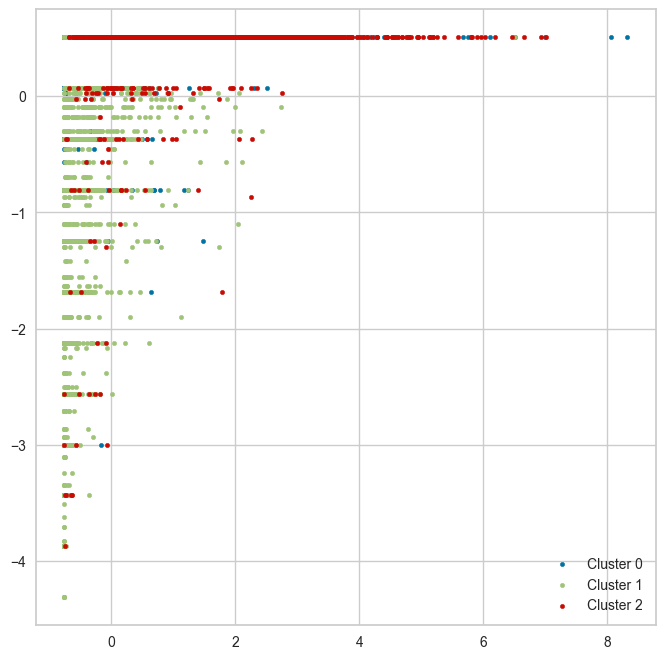

In [34]:
start = time.time()
agl_normal = AgglomerativeClustering(n_clusters=3)
agl_labels_normal = agl_normal.fit_predict(df_scaled)
end = time.time()

n_clusters = len(set(agl_normal.labels_))
results["AGL"]["normal"]["Silhouette Coefficient"] = silhouette_score(df_scaled, agl_labels_normal)
results["AGL"]["normal"]["Calinski-Harabasz Index"] = calinski_harabasz_score(df_scaled, agl_labels_normal)
results["AGL"]["normal"]["Davies-Bouldin Index"] = davies_bouldin_score(df_scaled, agl_labels_normal)
results["AGL"]["normal"]["Time"] = end - start
results["AGL"]["normal"]["N_clusters"] = n_clusters


for metric, value in results["AGL"]["normal"].items():
    print(f"{metric}: {value:.2f}")

DrawScatter(df_scaled, df_scaled, clusters = n_clusters, labels = agl_labels_normal, size_x=8, size_y=8)

Agglomerative Hierachical Clustering with UMAP

Silhouette Coefficient: 0.41
Calinski-Harabasz Index: 7782.16
Davies-Bouldin Index: 0.89
Time: 1.81
N_clusters: 3.00


C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", clusters)
C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[labels == i, 0], X[labels == i, 1], cmap = cmap, label=f'Cluster {i}', s=10)


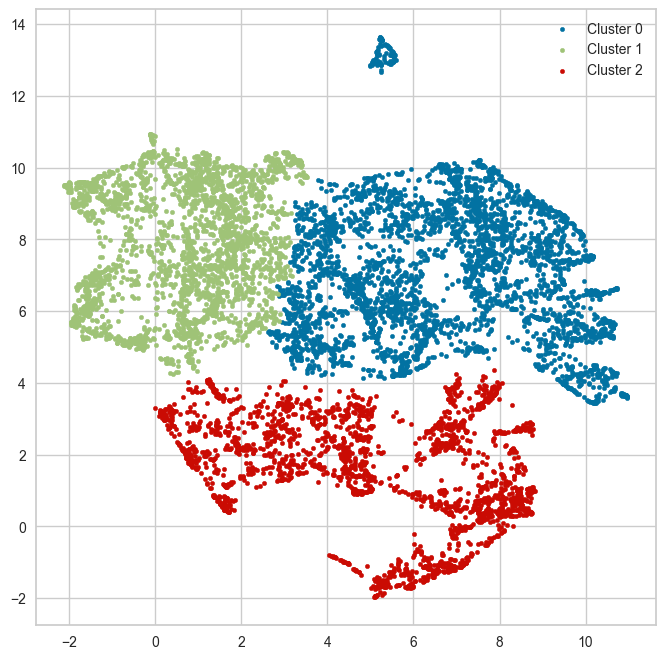

In [35]:
start = time.time()
agl_umap = AgglomerativeClustering(n_clusters=3)
agl_labels_umap = agl_umap.fit_predict(df_umap)
end = time.time()

n_clusters = len(set(agl_umap.labels_))
results["AGL"]["umap"]["Silhouette Coefficient"] = silhouette_score(df_umap, agl_labels_umap)
results["AGL"]["umap"]["Calinski-Harabasz Index"] = calinski_harabasz_score(df_umap, agl_labels_umap)
results["AGL"]["umap"]["Davies-Bouldin Index"] = davies_bouldin_score(df_umap, agl_labels_umap)
results["AGL"]["umap"]["Time"] = end - start
results["AGL"]["umap"]["N_clusters"] = n_clusters


for metric, value in results["AGL"]["umap"].items():
    print(f"{metric}: {value:.2f}")

DrawScatter(df_umap.values, df_umap.values, clusters = n_clusters, labels = agl_labels_umap, size_x=8, size_y=8)

Agglomerative Hierachical Clustering with PCA

Silhouette Coefficient: 0.38
Calinski-Harabasz Index: 3057.11
Davies-Bouldin Index: 0.98
Time: 2.18
N_clusters: 3.00


C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", clusters)
C:\Users\KDMoon\AppData\Local\Temp\ipykernel_29136\3085702494.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[labels == i, 0], X[labels == i, 1], cmap = cmap, label=f'Cluster {i}', s=10)


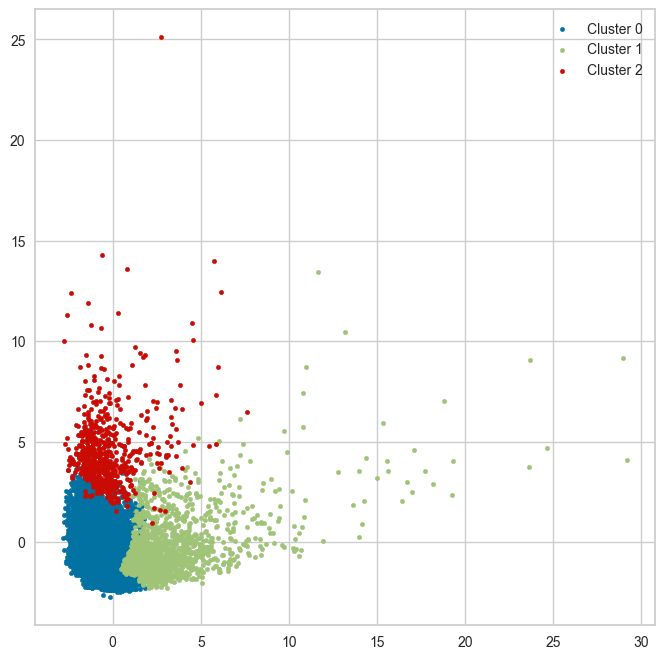

In [36]:
start = time.time()
agl_pca = AgglomerativeClustering(n_clusters=3)
agl_labels_pca = agl_pca.fit_predict(df_pca)
end = time.time()

n_clusters = len(set(agl_pca.labels_))
results["AGL"]["pca"]["Silhouette Coefficient"] = silhouette_score(df_pca, agl_labels_pca)
results["AGL"]["pca"]["Calinski-Harabasz Index"] = calinski_harabasz_score(df_pca, agl_labels_pca)
results["AGL"]["pca"]["Davies-Bouldin Index"] = davies_bouldin_score(df_pca, agl_labels_pca)
results["AGL"]["pca"]["Time"] = end - start
results["AGL"]["pca"]["N_clusters"] = n_clusters

for metric, value in results["AGL"]["pca"].items():
    print(f"{metric}: {value:.2f}")

n_clusters = len(set(agl_labels_pca)) - (1 if -1 in agl_labels_pca else 0) 
DrawScatter(df_pca, df_pca, clusters = n_clusters, labels = agl_labels_pca, size_x=8, size_y=8)

Results

In [37]:
from IPython.display import display, Markdown

def display_results(results):
    display(Markdown(f"### {url}"))
    display(Markdown(f"### {hopkins_score}"))
    for method, data in results.items():
        display(Markdown(f"### {method}"))
        for dataset, metrics in data.items():
            display(Markdown(f"#### {dataset}"))
            for metric, value in metrics.items():
                display(Markdown(f"- **{metric}**: {value:.6f}"))
                
display_results(results)


### CC GENERAL.csv

### 0.7929464183597794

### KMeans

#### normal

- **Silhouette Coefficient**: 0.205356

- **Calinski-Harabasz Index**: 1509.808354

- **Davies-Bouldin Index**: 1.662419

- **Time**: 0.012965

- **N_clusters**: 3.000000

#### umap

- **Silhouette Coefficient**: 0.438821

- **Calinski-Harabasz Index**: 8575.219940

- **Davies-Bouldin Index**: 0.808943

- **Time**: 0.066820

- **N_clusters**: 3.000000

#### pca

- **Silhouette Coefficient**: 0.372397

- **Calinski-Harabasz Index**: 3656.711615

- **Davies-Bouldin Index**: 0.981075

- **Time**: 0.060838

- **N_clusters**: 3.000000

### DBSCAN

#### normal

- **Silhouette Coefficient**: 0.521872

- **Calinski-Harabasz Index**: 901.354046

- **Davies-Bouldin Index**: 1.977591

- **Time**: 0.282243

- **N_clusters**: 2.000000

#### umap

- **Silhouette Coefficient**: -0.405457

- **Calinski-Harabasz Index**: 189.343706

- **Davies-Bouldin Index**: 1.755676

- **Time**: 0.055851

- **N_clusters**: 114.000000

#### pca

- **Silhouette Coefficient**: 0.538239

- **Calinski-Harabasz Index**: 333.848377

- **Davies-Bouldin Index**: 1.420870

- **Time**: 0.382973

- **N_clusters**: 6.000000

### GMM

#### normal

- **Silhouette Coefficient**: 0.115123

- **Calinski-Harabasz Index**: 887.558601

- **Davies-Bouldin Index**: 2.627679

- **Time**: 4.378285

- **N_clusters**: 3.000000

#### umap

- **Silhouette Coefficient**: 0.434888

- **Calinski-Harabasz Index**: 8328.812556

- **Davies-Bouldin Index**: 0.805201

- **Time**: 0.312164

- **N_clusters**: 3.000000

#### pca

- **Silhouette Coefficient**: 0.228561

- **Calinski-Harabasz Index**: 2255.517595

- **Davies-Bouldin Index**: 1.360865

- **Time**: 0.857702

- **N_clusters**: 3.000000

### AGL

#### normal

- **Silhouette Coefficient**: 0.178453

- **Calinski-Harabasz Index**: 1296.052863

- **Davies-Bouldin Index**: 1.784822

- **Time**: 2.607022

- **N_clusters**: 3.000000

#### umap

- **Silhouette Coefficient**: 0.412980

- **Calinski-Harabasz Index**: 7782.155664

- **Davies-Bouldin Index**: 0.885463

- **Time**: 1.807163

- **N_clusters**: 3.000000

#### pca

- **Silhouette Coefficient**: 0.378671

- **Calinski-Harabasz Index**: 3057.109079

- **Davies-Bouldin Index**: 0.979650

- **Time**: 2.180165

- **N_clusters**: 3.000000

In [38]:
columns = ["Algorithm", "Dimensionality Reduction", "Metric", "Value"]

# Convert the result to a list
results_list = []
for algorithm in results:
    for reduction in results[algorithm]:
        for metric, value in results[algorithm][reduction].items():
            results_list.append([algorithm, reduction, metric, value])

# Convert the list to a dataframe
df_result = pd.DataFrame(results_list, columns=columns)

# printt the results as a table
# print(df_result.to_string())

# save result to file
with open(url+"_result.csv", "w", newline="") as f:
    f.write(f"Hopkins Score : {hopkins_score}\n")
    df_result.to_csv(f)